# **Random Forests V2**

We’ve seen that decision trees can be powerful supervised machine learning models. However, they’re not without their weaknesses — decision trees are often prone to overfitting. We’ve discussed some strategies to minimize this problem, like pruning, but sometimes that isn’t enough. We need to find another way to generalize our trees. This is where the concept of a random forest comes in handy.

A random forest is an *ensemble machine learning technique*. A random forest contains many decision trees that all work together to classify new points. When a random forest is asked to classify a new point, the random forest gives that point to each of the decision trees. Each of those trees reports their classification and the random forest returns the most popular classification. It’s like every tree gets a vote, and the most popular classification wins. Some of the trees in the random forest may be overfit, but by making the prediction based on a large number of trees, overfitting will have less of an impact.

## Bootstrapping

You might be wondering how the trees in the random forest get created. After all, right now, our algorithm for creating a decision tree is deterministic — given a training set, the same tree will be made every time. To make a random forest, we use a technique called *bagging*, which is short for *bootstrap aggregating*. This exercise will explain bootstrapping, which is a type of sampling method done with replacement.

How it works is as follows: every time a decision tree is made, it is created using a different subset of the points in the training set. For example, if our training set had `1000` rows in it, we could make a decision tree by picking `100` of those rows at random to build the tree. This way, every tree is different, but all trees will still be created from a portion of the training data.

In bootstrapping, we’re doing this process with replacement. Picture putting all `100` rows in a bag and reaching in and grabbing one row at random. After writing down what row we picked, we put that row back in our bag. This means that when we’re picking our `100` random rows, we could pick the same row more than once. In fact, it’s very unlikely, but all `100` randomly picked rows could all be the same row! Because we’re picking these rows with replacement, there’s no need to shrink our bagged training set from `1000` rows to `100`. We can pick `1000` rows at random, and because we can get the same row more than once, we’ll still end up with a unique data set.

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier

In [31]:
# import the data
drugs = pd.read_csv("drug_consumption.csv")
# filter out unnecessary columns
drugs.drop("ID", inplace=True, axis=1)
drugs.drop(drugs.iloc[:, 12:27], inplace=True, axis=1)
drugs.drop(drugs.iloc[:, -3:], inplace=True, axis=1)
drugs.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,AScore,Cscore,Impulsive,SS,Mushrooms
0,25-34,M,Doctorate degree,UK,White,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL0
1,35-44,M,Professional certificate/ diploma,UK,White,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL1
2,18-24,F,Masters degree,UK,White,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL0
3,35-44,F,Doctorate degree,UK,White,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL2
4,65+,F,Left school at 18 years,Canada,White,-0.67825,-0.30033,-1.55521,2.03972,1.63088,-1.37983,-1.54858,CL0


In [32]:
# print the number of rows and the distribution of gender
nrows = drugs.shape[0]
print(nrows) 
print(f'Distribution of gender in {nrows} rows of data:')
print(drugs.Gender.value_counts(normalize=True))

1884
Distribution of gender in 1884 rows of data:
M    0.500531
F    0.499469
Name: Gender, dtype: float64


In [33]:
# create a bootstrapped sample
boot_sample = drugs.sample(nrows, replace=True)
print(f'Distribution of gender in bootstrapped sample data:')
print(boot_sample.Gender.value_counts(normalize=True))

Distribution of gender in bootstrapped sample data:
F    0.520701
M    0.479299
Name: Gender, dtype: float64


0.4909294055201699


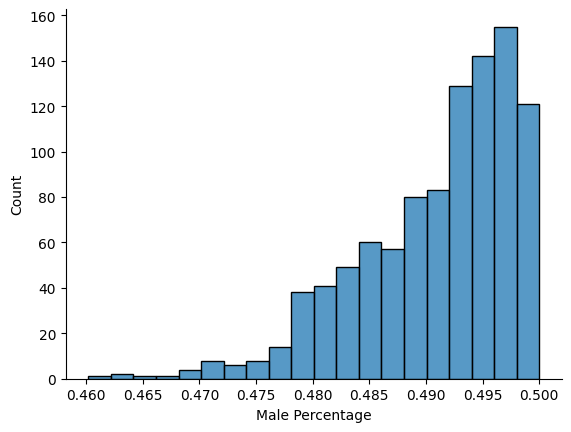

In [34]:
# create 1,000 bootstrapped samples
male_perc = []
for i in range(1000):
    boot_sample = drugs.sample(nrows, replace=True)
    value_counts = boot_sample.Gender.value_counts(normalize=True)
    male_perc.append(value_counts[1])

# view the distribution of the result
mean_mp = np.mean(male_perc)
print(mean_mp)

sns.histplot(male_perc, bins=20)
plt.xlabel('Male Percentage')
sns.despine()

## Bagging

Random forests create different trees using a process known as bagging, which is short for bootstrapped aggregating. As we already covered bootstrapping, the process starts with creating a single decision tree on a bootstrapped sample of data points in the training set. Then after many trees have been made, the results are “aggregated” together. In the case of a classification task, often the aggregation is taking the majority vote of the individual classifiers. For regression tasks, often the aggregation is the average of the individual regressors.

We will dive into this process for the drug consumption dataset we used in the previous exercise. The dataset has 12 features:
- age
- gender
- education
- country of current residence
- ethnicity
- neuroticism score
- extraversion score
- openness to experience score
- agreeableness score
- conscientiousness score
- impulsiveness score
- sensation seeing score

Our target variable for prediction is `Mushrooms` or whether or not the drug has been used in the last 12 months or not and can either be `0` or `1`.

In [35]:
# map the categorical variables into a numeric representation
age_map = {"18-24": 0, "25-34": 1, "35-44": 2, "45-54": 3, "55-64": 4, "65+": 5}
educ_map = {"Left school before 16 years": 0, "Left school at 16 years": 1, "Left school at 17 years": 2, "Left school at 18 years": 3,
            "Some college or university, no certificate or degree": 4, "Professional certificate/ diploma": 5, "University degree": 6, 
            "Masters degree": 7, "Doctorate degree": 8}
user_map = {'CL0': 0, 'CL1': 0, 'CL2': 0, 'CL3': 1, 'CL4': 1, 'CL5': 1, 'CL6': 1}

dicts = [age_map, educ_map, user_map]
for col, enc in zip(drugs[['Age', 'Education', 'Mushrooms']], dicts):
    drugs[col] = drugs[col].map(lambda x: enc.get(x, x))

enc = OrdinalEncoder()
encoded_cols = enc.fit_transform(drugs[['Gender', 'Country', 'Ethnicity']])
drugs[['Gender', 'Country', 'Ethnicity']] = encoded_cols
drugs.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,AScore,Cscore,Impulsive,SS,Mushrooms
0,1,1.0,8,5.0,6.0,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,0
1,2,1.0,5,5.0,6.0,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,0
2,0,0.0,7,5.0,6.0,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,0
3,2,0.0,8,5.0,6.0,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,0
4,5,0.0,3,1.0,6.0,-0.67825,-0.30033,-1.55521,2.03972,1.63088,-1.37983,-1.54858,0


In [36]:
# split the data into 75% train and 25% validation
y = drugs.Mushrooms
X = drugs.drop('Mushrooms', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, stratify=y, random_state=0)

# fit a decision tree with a max depth of 5
dt_clf = DecisionTreeClassifier(max_depth=5)
dt_clf.fit(X_train, y_train)
dt_clf.score(X_test, y_test)

0.7664543524416136

In [37]:
# fit the decision tree on a bootstrapped sample
idxs = X_train.sample(X_train.shape[0], replace=True, random_state=0).index
dt_clf.fit(X_train.loc[idxs], y_train.loc[idxs])
dt_clf.score(X_test, y_test)

0.7643312101910829

In [38]:
# repeat 10 times and extract predictions on the test set
preds = []
random_state = 0
for i in range(10):
    idxs = X_train.sample(X_train.shape[0], replace=True, random_state=random_state + 1).index
    
    dt_clf.fit(X_train.loc[idxs], y_train.loc[idxs])
    pred = dt_clf.predict(X_test)
    preds.append(pred)
ba_pred = np.array(preds).mean(0)

# calculate the overall accuracy
ba_accuracy = accuracy_score(y_test, ba_pred >= 0.5)
ba_accuracy

0.7707006369426752

## Random Forest Feature Selection

In addition to using bootstrapped samples of our dataset, we can continue to add variety to the ways our trees are created by randomly selecting the features that are used.

When we use a decision tree, all the features are used and the split is chosen as the one that increases the information gain the most. While it may seem counter-intuitive, selecting a random subset of features can help in the performance of an ensemble model. In the following example, we will use a random selection of features prior to model building to add additional variance to the individual trees. While an individual tree may perform worse, sometimes the increases in variance can help model performance of the ensemble model as a whole.


In [39]:
# select 4 random features from the 12 available
rand_features = np.random.choice(X_train.columns, 4)
print(rand_features)

# fit a decision tree on this subset and assess model accuracy
dt_clf = DecisionTreeClassifier()

dt_clf.fit(X_train[rand_features], y_train)
dt_clf.score(X_test[rand_features], y_test)

['Gender' 'Education' 'Impulsive' 'Country']


0.772823779193206

In [40]:
# repeat 10 times, using a different subset of features each time
preds = []
for i in range(10):
    rand_features = np.random.choice(X_train.columns, 4)
    print(rand_features)
    
    dt_clf.fit(X_train[rand_features], y_train)
    pred = dt_clf.predict(X_test[rand_features])
    preds.append(pred)

# calculate an aggregate prediction
prob_preds = np.array(preds).mean(0)
agg_preds = prob_preds >= 0.5
agg_accuracy = accuracy_score(y_test, agg_preds)
agg_accuracy

['Ethnicity' 'Impulsive' 'Nscore' 'Education']
['Country' 'SS' 'Nscore' 'Nscore']
['Cscore' 'Cscore' 'Education' 'Gender']
['AScore' 'Education' 'Nscore' 'Impulsive']
['Education' 'AScore' 'Country' 'Nscore']
['Oscore' 'Nscore' 'Ethnicity' 'SS']
['Gender' 'Education' 'Country' 'Age']
['Education' 'SS' 'Age' 'Age']
['Cscore' 'Escore' 'AScore' 'Escore']
['Oscore' 'Cscore' 'Cscore' 'Ethnicity']


0.8110403397027601

## Bagging in `scikit-learn`

The two steps we walked through above created trees on bootstrapped samples and randomly selecting features. These can be combined together and implemented at the same time! Combining them adds an additional variation to the base learners for the ensemble model. This in turn increases the ability of the model to generalize to new and unseen data, i.e., it minimizes bias and increases variance. Rather than re-doing this process manually, we will use `scikit-learn's` bagging implementation, `BaggingClassifier()`, to do so.

Much like other models we have used in `scikit-learn`, we instantiate a instance of `BaggingClassifier()` and specify the parameters. The first parameter, base_estimator refers to the machine learning model that is being bagged. In the case of random forests, the base estimator would be a decision tree. We are going to use a decision tree classifier WITH a `max_depth` of 5, this will be instantiated with `BaggingClassifier(DecisionTreeClassifier(max_depth=5))`.

After the model has been defined, methods `.fit()`, `.predict()`, `.score()` can be used as expected. Additional hyperparameters specific to bagging include the number of estimators (`n_estimators`) we want to use and the maximum number of features we’d like to keep (`max_features`).

Note: While we have focused on decision tress classifiers (as this is the base learner for a random forest classifier), this procedure of bagging is not specific to decision trees, and in fact can be used for any base classifier or regression model. The `scikit-learn` implementation is generalizable and can be used for other base models!

In [41]:
# initialise a bagging classifier with a decision tree as a base classifier
bag_dt = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=10)

bag_dt.fit(X_train, y_train)
pred = bag_dt.predict(X_test)
bag_accuracy = accuracy_score(y_test, pred)
bag_accuracy

0.8067940552016986

In [42]:
# initialise a bagging classifier with a decision tree as a base classifier
# restrict the number of features to 10
bag_dt_10 = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=10, max_features=10)

bag_dt_10.fit(X_train, y_train)
pred = bag_dt_10.predict(X_test)
bag_accuracy = accuracy_score(y_test, pred)
bag_accuracy

0.8089171974522293

In [43]:
# change the base estimator to a logistic regression
bag_lr = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=10, max_features=10)

bag_lr.fit(X_train, y_train)
pred = bag_lr.predict(X_test)
bag_accuracy = accuracy_score(y_test, pred)
bag_accuracy

0.8089171974522293

## Train and Predict using `scikit-learn`

Now that we have covered two major ways to combine trees, both in terms of samples and features, we are ready to get to the implementation of random forests! This will be similar to what we covered in the previous exercises, but the random forest algorithm has a slightly different way of randomly choosing features. Rather than choosing a single random set at the onset, each split chooses a different random set.

For example, when finding which feature to split the data on the first time, we might randomly choose to only consider age, country and education. After splitting the data on the best feature from that subset, we’ll likely want to split again. For this next split, we’ll randomly select three features again to consider. This time those features might be ethnicity, impulsiveness and education. We’ll continue this process until the tree is complete.

One question to consider is how to choose the number of features to randomly select. Why did we choose 3 in this example? A good rule of thumb is select as many features as the square root of the total number of features. Our drugs dataset doesn’t have a lot of features, so in this example, it’s difficult to follow this rule. But if we had a dataset with 25 features, we’d want to randomly select 5 features to consider at every split point.

You now have the ability to make a random forest using your own decision trees. However, `scikit-learn` has a `RandomForestClassifier()` class that will do all of this work for you!

`RandomForestClassifier()` works almost identically to `DecisionTreeClassifier()` — the `.fit()`, `.predict()`, and `.score()` methods work in the exact same way.

In [44]:
# initialise a random forest classifier and view available parameters/hyperparameters
rf = RandomForestClassifier()
print(rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [45]:
# fit on the training data and view model accuracy
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
accuracy_score(y_test, preds)

0.8131634819532909

In [46]:
# view other performance metrics
rf_precision = precision_score(y_test, preds)
rf_recall = recall_score(y_test, preds)
rf_cm = confusion_matrix(y_test, preds)

print(f'Model precision: {rf_precision}')
print(f'Model recall: {rf_recall}')
print('Confusion matrix:')
print(rf_cm)

Model precision: 0.6041666666666666
Model recall: 0.5370370370370371
Confusion matrix:
[[325  38]
 [ 50  58]]


## Random Forest Regressor

Just like in decision trees, we can use random forests for regression as well! It is important to know when to use regression or classification — this usually comes down to what type of variable your target is. Previously, we were using a binary categorical variable (acceptable versus not), so a classification model was used.

We will now consider a hypothetical new target variable, `usage`, for this data set, which is a continuous variable. We’ve generated some fake drug use amounts in the dataset so that we have numerical values instead of the previous categorical variables.

Now, instead of a classification task, we will use `scikit-learn's RandomForestRegressor()` to carry out a regression task.

Note: Recall that the default evaluation metric for regressors in `scikit-learn` is the R-squared score.

In [47]:
usage = np.random.normal(loc=5, size=drugs.shape[0])
drugs['Usage'] = usage
drugs.Usage.describe()

# drop the binary target variable
drugs.drop('Mushrooms', inplace=True, axis=1)

In [48]:
drugs.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,AScore,Cscore,Impulsive,SS,Usage
0,1,1.0,8,5.0,6.0,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,4.575508
1,2,1.0,5,5.0,6.0,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,3.890947
2,0,0.0,7,5.0,6.0,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,2.271166
3,2,0.0,8,5.0,6.0,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,3.669276
4,5,0.0,3,1.0,6.0,-0.67825,-0.30033,-1.55521,2.03972,1.63088,-1.37983,-1.54858,4.177870


In [53]:
# split the data into 75% train and 25% validation
# y = drugs.Usage
# X = drugs.drop('Usage', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=0)

# fit a random forest regression model
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

r_squared_train = rfr.score(X_train, y_train)
print(f'Train set R^2: {r_squared_train}')

r_squared_test = rfr.score(X_test, y_test)
print(f'Test set R^2: {r_squared_test}')

Train set R^2: 0.8565104763893777
Test set R^2: -0.06913778796660353


In [61]:
avg_usage = np.mean(y)
print(f'True average usage: {avg_usage}')

train_pred = rfr.predict(X_train)
test_pred = rfr.predict(X_test)
mae_train = mean_absolute_error(y_train, train_pred)
print(f'Train MAE: {mae_train}')
mae_test = mean_absolute_error(y_test, test_pred)
print(f'Test MAE: {mae_test}')

True average usage: 4.981528955785005
Train MAE: 0.30397543751531797
Test MAE: 0.8895955882291855


## Review

Here are some of the major takeaways about random forests:
- A random forest is an ensemble machine learning model. It makes a classification by aggregating the classifications of many decision trees.
- Random forests are used to avoid overfitting. By aggregating the classification of multiple trees, having overfitted trees in a random forest is less impactful.
- Every decision tree in a random forest is created by using a different subset of data points from the training set. Those data points are chosen at random with replacement, which means a single data point can be chosen more than once. This process is known as bagging.
- When creating a tree in a random forest, a randomly selected subset of features are considered as candidates for the best splitting feature. If your dataset has `n` features, it is common practice to randomly select the square root of `n` features.